In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import os

In [2]:
# checkpoint -> result 불러오기
import argparse
from exp.exp_long_term_forecasting import Exp_Long_Term_Forecast
from exp.exp_imputation import Exp_Imputation
from exp.exp_short_term_forecasting import Exp_Short_Term_Forecast
from exp.exp_long_term_forecasting_partial import Exp_Long_Term_Forecast_Partial
from exp.exp_anomaly_detection import Exp_Anomaly_Detection
from exp.exp_classification import Exp_Classification
from utils.print_args import print_args
import random
import time
from utils.metrics import *
from utils.tools import EarlyStopping

In [3]:
# fix random seed
fix_seed = 2021
random.seed(fix_seed)
torch.manual_seed(fix_seed)
np.random.seed(fix_seed)
parser = argparse.ArgumentParser(description='TimesNet')

In [4]:
# config 지정 -> 오류 방지를 위해 

# basic config
parser.add_argument('--task_name', type=str, default='long_term_forecast',
                    help='task name, options:[long_term_forecast, short_term_forecast, imputation, classification, anomaly_detection]')
parser.add_argument('--is_training', type=int, default=1, help='status')
parser.add_argument('--model_id', type=str, default='test', help='model id')
parser.add_argument('--model', type=str, default='Autoformer',
                    help='model name, options: [Autoformer, Transformer, TimesNet]')

# data loader
parser.add_argument('--data', type=str, default='ETTm1', help='dataset type')
parser.add_argument('--root_path', type=str, default='./data/ETT/', help='root path of the data file')
parser.add_argument('--data_path', type=str, default='ETTh1.csv', help='data file')
parser.add_argument('--features', type=str, default='M',
                    help='forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate')
parser.add_argument('--target', type=str, default='OT', help='target feature in S or MS task')
parser.add_argument('--freq', type=str, default='h',
                    help='freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h')
parser.add_argument('--checkpoints', type=str, default='./checkpoints/', help='location of model checkpoints')

# added option 
parser.add_argument('--train_ratio', type=float, default=0.7, help='train data ratio')
parser.add_argument('--test_ratio', type=float, default=0.2, help='test data ratio')
parser.add_argument('--train_step', type=float, default=1.0, help='train data with certain stes. for example train_step=2 means only train even number of data')

# SparseTSF
parser.add_argument('--period_len', type=int, default=24, help='period length')

# PITS
parser.add_argument('--fc_dropout', type=float, default=0.05, help='fully connected dropout')
parser.add_argument('--head_dropout', type=float, default=0.0, help='head dropout')
parser.add_argument('--patch_len', type=int, default=16, help='patch length')
parser.add_argument('--stride', type=int, default=8, help='stride')
parser.add_argument('--shared_embedding', type=int, default=1, help='stride')
parser.add_argument('--padding_patch', default='end', help='None: None; end: padding on the end')
parser.add_argument('--revin', type=int, default=1, help='RevIN; True 1 False 0')
parser.add_argument('--affine', type=int, default=0, help='RevIN-affine; True 1 False 0')
parser.add_argument('--subtract_last', type=int, default=0, help='0: subtract mean; 1: subtract last')
parser.add_argument('--decomposition', type=int, default=0, help='decomposition; True 1 False 0')
parser.add_argument('--kernel_size', type=int, default=25, help='decomposition-kernel')
parser.add_argument('--individual', type=int, default=0, help='individual head; True 1 False 0')

# Piformer
parser.add_argument('--joint_var', type=int, default=0, help='use attention for each patching; True 1 False 0')

# forecasting task
parser.add_argument('--seq_len', type=int, default=96, help='input sequence length')
parser.add_argument('--label_len', type=int, default=48, help='start token length')
parser.add_argument('--pred_len', type=int, default=96, help='prediction sequence length')
parser.add_argument('--seasonal_patterns', type=str, default='Monthly', help='subset for M4')
parser.add_argument('--inverse', action='store_true', help='inverse output data', default=False)

# inputation task
parser.add_argument('--mask_rate', type=float, default=0.25, help='mask ratio')

# anomaly detection task
parser.add_argument('--anomaly_ratio', type=float, default=0.25, help='prior anomaly ratio (%)')

# model define
parser.add_argument('--expand', type=int, default=2, help='expansion factor for Mamba')
parser.add_argument('--d_conv', type=int, default=4, help='conv kernel size for Mamba')
parser.add_argument('--top_k', type=int, default=5, help='for TimesBlock')
parser.add_argument('--num_kernels', type=int, default=6, help='for Inception')
parser.add_argument('--enc_in', type=int, default=7, help='encoder input size')
parser.add_argument('--dec_in', type=int, default=7, help='decoder input size')
parser.add_argument('--c_out', type=int, default=7, help='output size')
parser.add_argument('--d_model', type=int, default=512, help='dimension of model')
parser.add_argument('--n_heads', type=int, default=8, help='num of heads')
parser.add_argument('--e_layers', type=int, default=2, help='num of encoder layers')
parser.add_argument('--d_layers', type=int, default=1, help='num of decoder layers')
parser.add_argument('--d_ff', type=int, default=2048, help='dimension of fcn')
parser.add_argument('--moving_avg', type=int, default=25, help='window size of moving average')
parser.add_argument('--factor', type=int, default=1, help='attn factor')
parser.add_argument('--distil', action='store_false',
                    help='whether to use distilling in encoder, using this argument means not using distilling',
                    default=True)
parser.add_argument('--dropout', type=float, default=0.1, help='dropout')
parser.add_argument('--embed', type=str, default='timeF',
                    help='time features encoding, options:[timeF, fixed, learned]')
parser.add_argument('--activation', type=str, default='gelu', help='activation')
parser.add_argument('--output_attention', action='store_true', help='whether to output attention in ecoder')
parser.add_argument('--channel_independence', type=int, default=1,
                    help='0: channel dependence 1: channel independence for FreTS model')
parser.add_argument('--decomp_method', type=str, default='moving_avg',
                    help='method of series decompsition, only support moving_avg or dft_decomp')
parser.add_argument('--use_norm', type=int, default=1, help='whether to use normalize; True 1 False 0')
parser.add_argument('--down_sampling_layers', type=int, default=0, help='num of down sampling layers')
parser.add_argument('--down_sampling_window', type=int, default=1, help='down sampling window size')
parser.add_argument('--down_sampling_method', type=str, default=None,
                    help='down sampling method, only support avg, max, conv')
parser.add_argument('--seg_len', type=int, default=48,
                    help='the length of segmen-wise iteration of SegRNN')

# optimization
parser.add_argument('--num_workers', type=int, default=10, help='data loader num workers')
parser.add_argument('--itr', type=int, default=1, help='experiments times')
parser.add_argument('--train_epochs', type=int, default=10, help='train epochs')
parser.add_argument('--batch_size', type=int, default=32, help='batch size of train input data')
parser.add_argument('--patience', type=int, default=3, help='early stopping patience')
parser.add_argument('--learning_rate', type=float, default=0.0001, help='optimizer learning rate')
parser.add_argument('--des', type=str, default='test', help='exp description')
parser.add_argument('--loss', type=str, default='MSE', help='loss function')
parser.add_argument('--lradj', type=str, default='type1', help='adjust learning rate')
parser.add_argument('--use_amp', action='store_true', help='use automatic mixed precision training', default=False)

# GPU
parser.add_argument('--use_gpu', type=bool, default=True, help='use gpu')
parser.add_argument('--gpu', type=int, default=0, help='gpu')
parser.add_argument('--use_multi_gpu', action='store_true', help='use multiple gpus', default=False)
parser.add_argument('--devices', type=str, default='0,1,2,3', help='device ids of multile gpus')

# de-stationary projector params
parser.add_argument('--p_hidden_dims', type=int, nargs='+', default=[128, 128],
                    help='hidden layer dimensions of projector (List)')
parser.add_argument('--p_hidden_layers', type=int, default=2, help='number of hidden layers in projector')

# metrics (dtw)
parser.add_argument('--use_dtw', type=bool, default=False, 
                    help='the controller of using dtw metric (dtw is time consuming, not suggested unless necessary)')

# Augmentation
parser.add_argument('--augmentation_ratio', type=int, default=0, help="How many times to augment")
parser.add_argument('--seed', type=int, default=2, help="Randomization seed")
parser.add_argument('--jitter', default=False, action="store_true", help="Jitter preset augmentation")
parser.add_argument('--scaling', default=False, action="store_true", help="Scaling preset augmentation")
parser.add_argument('--permutation', default=False, action="store_true", help="Equal Length Permutation preset augmentation")
parser.add_argument('--randompermutation', default=False, action="store_true", help="Random Length Permutation preset augmentation")
parser.add_argument('--magwarp', default=False, action="store_true", help="Magnitude warp preset augmentation")
parser.add_argument('--timewarp', default=False, action="store_true", help="Time warp preset augmentation")
parser.add_argument('--windowslice', default=False, action="store_true", help="Window slice preset augmentation")
parser.add_argument('--windowwarp', default=False, action="store_true", help="Window warp preset augmentation")
parser.add_argument('--rotation', default=False, action="store_true", help="Rotation preset augmentation")
parser.add_argument('--spawner', default=False, action="store_true", help="SPAWNER preset augmentation")
parser.add_argument('--dtwwarp', default=False, action="store_true", help="DTW warp preset augmentation")
parser.add_argument('--shapedtwwarp', default=False, action="store_true", help="Shape DTW warp preset augmentation")
parser.add_argument('--wdba', default=False, action="store_true", help="Weighted DBA preset augmentation")
parser.add_argument('--discdtw', default=False, action="store_true", help="Discrimitive DTW warp preset augmentation")
parser.add_argument('--discsdtw', default=False, action="store_true", help="Discrimitive shapeDTW warp preset augmentation")
parser.add_argument('--extra_tag', type=str, default="", help="Anything extra")

#piformer
parser.add_argument('--shuffle', type=int, default=1, help="Shuffle data when training")
parser.add_argument('--base_model', type=str, default="iTransformer", help="Base Model Type")

_StoreAction(option_strings=['--base_model'], dest='base_model', nargs=None, const=None, default='iTransformer', type=<class 'str'>, choices=None, help='Base Model Type', metavar=None)

In [5]:
# 스크립트 4개 정리 (./scripts/long_term_forecast/Multi_script/iTransformer_exchange_weather.sh)
scripts_list = ["""--task_name long_term_forecast \
  --is_training 1 \
  --root_path ./dataset/exchange_rate/ \
  --data_path exchange_rate.csv \
  --model_id iTransformer_Exchange_96_96 \
  --model iTransformer \
  --data custom \
  --features M \
  --seq_len 96 \
  --label_len 48 \
  --pred_len 96 \
  --e_layers 2 \
  --d_layers 1 \
  --factor 3 \
  --enc_in 8 \
  --dec_in 8 \
  --c_out 8 \
  --batch_size 8 \
  --d_model 64\
  --d_ff 128\
  --des 'Exp' \
  --itr 1 """,
                """--task_name long_term_forecast \
  --is_training 1 \
  --root_path ./dataset/exchange_rate/ \
  --data_path exchange_rate.csv \
  --model_id iTransformer_Exchange_96_192 \
  --model iTransformer \
  --data custom \
  --features M \
  --seq_len 96 \
  --label_len 48 \
  --pred_len 192 \
  --e_layers 2 \
  --d_layers 1 \
  --factor 3 \
  --enc_in 8 \
  --dec_in 8 \
  --c_out 8 \
  --batch_size 8 \
  --d_model 64\
  --d_ff 128\
  --des 'Exp' \
  --itr 1 """,
                """--task_name long_term_forecast \
  --is_training 1 \
  --root_path ./dataset/weather/ \
  --data_path weather.csv \
  --model_id iTransformer_weather_96_96 \
  --model iTransformer \
  --data custom \
  --features M \
  --seq_len 96 \
  --label_len 48 \
  --pred_len 96 \
  --e_layers 3 \
  --d_layers 1 \
  --factor 3 \
  --enc_in 21 \
  --dec_in 21 \
  --c_out 21 \
  --des 'Exp' \
  --batch_size 8 \
  --d_model 64\
  --d_ff 128\
  --itr 1""",
                """--task_name long_term_forecast \
  --is_training 1 \
  --root_path ./dataset/weather/ \
  --data_path weather.csv \
  --model_id iTransformer_weather_96_192 \
  --model iTransformer \
  --data custom \
  --features M \
  --seq_len 96 \
  --label_len 48 \
  --pred_len 192 \
  --e_layers 3 \
  --d_layers 1 \
  --factor 3 \
  --enc_in 21 \
  --dec_in 21 \
  --c_out 21 \
  --des 'Exp' \
  --batch_size 8 \
  --d_model 64\
  --d_ff 128\
  --itr 1 """]

In [6]:
args0 = parser.parse_args(scripts_list[0].split())
args0.use_gpu = True if torch.cuda.is_available() and args0.use_gpu else False

if args0.use_gpu and args0.use_multi_gpu:
    args0.devices = args0.devices.replace(' ', '')
    device_ids0 = args0.devices.split(',')
    args0.device_ids = [int(id_) for id_ in device_ids0]
    args0.gpu = args0.device_ids[0]

print('Args in experiment:')
print(args0)

Args in experiment:
Namespace(activation='gelu', affine=0, anomaly_ratio=0.25, augmentation_ratio=0, base_model='iTransformer', batch_size=8, c_out=8, channel_independence=1, checkpoints='./checkpoints/', d_conv=4, d_ff=128, d_layers=1, d_model=64, data='custom', data_path='exchange_rate.csv', dec_in=8, decomp_method='moving_avg', decomposition=0, des="'Exp'", devices='0,1,2,3', discdtw=False, discsdtw=False, distil=True, down_sampling_layers=0, down_sampling_method=None, down_sampling_window=1, dropout=0.1, dtwwarp=False, e_layers=2, embed='timeF', enc_in=8, expand=2, extra_tag='', factor=3, fc_dropout=0.05, features='M', freq='h', gpu=0, head_dropout=0.0, individual=0, inverse=False, is_training=1, itr=1, jitter=False, joint_var=0, kernel_size=25, label_len=48, learning_rate=0.0001, loss='MSE', lradj='type1', magwarp=False, mask_rate=0.25, model='iTransformer', model_id='iTransformer_Exchange_96_96', moving_avg=25, n_heads=8, num_kernels=6, num_workers=10, output_attention=False, p_h

In [7]:
args1 = parser.parse_args(scripts_list[1].split())
args1.use_gpu = True if torch.cuda.is_available() and args1.use_gpu else False

if args1.use_gpu and args1.use_multi_gpu:
    args1.devices = args1.devices.replace(' ', '')
    device_ids1 = args1.devices.split(',')
    args1.device_ids = [int(id_) for id_ in device_ids1]
    args1.gpu = args1.device_ids[0]

print('Args in experiment:')
print(args1)

Args in experiment:
Namespace(activation='gelu', affine=0, anomaly_ratio=0.25, augmentation_ratio=0, base_model='iTransformer', batch_size=8, c_out=8, channel_independence=1, checkpoints='./checkpoints/', d_conv=4, d_ff=128, d_layers=1, d_model=64, data='custom', data_path='exchange_rate.csv', dec_in=8, decomp_method='moving_avg', decomposition=0, des="'Exp'", devices='0,1,2,3', discdtw=False, discsdtw=False, distil=True, down_sampling_layers=0, down_sampling_method=None, down_sampling_window=1, dropout=0.1, dtwwarp=False, e_layers=2, embed='timeF', enc_in=8, expand=2, extra_tag='', factor=3, fc_dropout=0.05, features='M', freq='h', gpu=0, head_dropout=0.0, individual=0, inverse=False, is_training=1, itr=1, jitter=False, joint_var=0, kernel_size=25, label_len=48, learning_rate=0.0001, loss='MSE', lradj='type1', magwarp=False, mask_rate=0.25, model='iTransformer', model_id='iTransformer_Exchange_96_192', moving_avg=25, n_heads=8, num_kernels=6, num_workers=10, output_attention=False, p_

In [8]:
args2 = parser.parse_args(scripts_list[2].split())
args2.use_gpu = True if torch.cuda.is_available() and args2.use_gpu else False

if args2.use_gpu and args2.use_multi_gpu:
    args2.devices = args2.devices.replace(' ', '')
    device_ids2 = args2.devices.split(',')
    args2.device_ids = [int(id_) for id_ in device_ids2]
    args2.gpu = args2.device_ids[0]

print('Args in experiment:')
print(args2)

Args in experiment:
Namespace(activation='gelu', affine=0, anomaly_ratio=0.25, augmentation_ratio=0, base_model='iTransformer', batch_size=8, c_out=21, channel_independence=1, checkpoints='./checkpoints/', d_conv=4, d_ff=128, d_layers=1, d_model=64, data='custom', data_path='weather.csv', dec_in=21, decomp_method='moving_avg', decomposition=0, des="'Exp'", devices='0,1,2,3', discdtw=False, discsdtw=False, distil=True, down_sampling_layers=0, down_sampling_method=None, down_sampling_window=1, dropout=0.1, dtwwarp=False, e_layers=3, embed='timeF', enc_in=21, expand=2, extra_tag='', factor=3, fc_dropout=0.05, features='M', freq='h', gpu=0, head_dropout=0.0, individual=0, inverse=False, is_training=1, itr=1, jitter=False, joint_var=0, kernel_size=25, label_len=48, learning_rate=0.0001, loss='MSE', lradj='type1', magwarp=False, mask_rate=0.25, model='iTransformer', model_id='iTransformer_weather_96_96', moving_avg=25, n_heads=8, num_kernels=6, num_workers=10, output_attention=False, p_hidde

In [9]:
args3 = parser.parse_args(scripts_list[3].split())
args3.use_gpu = True if torch.cuda.is_available() and args1.use_gpu else False

if args3.use_gpu and args3.use_multi_gpu:
    args1.devices = args3.devices.replace(' ', '')
    device_ids3 = args3.devices.split(',')
    args3.device_ids = [int(id_) for id_ in device_ids3]
    args3.gpu = args3.device_ids[0]

print('Args in experiment:')
print(args3)

Args in experiment:
Namespace(activation='gelu', affine=0, anomaly_ratio=0.25, augmentation_ratio=0, base_model='iTransformer', batch_size=8, c_out=21, channel_independence=1, checkpoints='./checkpoints/', d_conv=4, d_ff=128, d_layers=1, d_model=64, data='custom', data_path='weather.csv', dec_in=21, decomp_method='moving_avg', decomposition=0, des="'Exp'", devices='0,1,2,3', discdtw=False, discsdtw=False, distil=True, down_sampling_layers=0, down_sampling_method=None, down_sampling_window=1, dropout=0.1, dtwwarp=False, e_layers=3, embed='timeF', enc_in=21, expand=2, extra_tag='', factor=3, fc_dropout=0.05, features='M', freq='h', gpu=0, head_dropout=0.0, individual=0, inverse=False, is_training=1, itr=1, jitter=False, joint_var=0, kernel_size=25, label_len=48, learning_rate=0.0001, loss='MSE', lradj='type1', magwarp=False, mask_rate=0.25, model='iTransformer', model_id='iTransformer_weather_96_192', moving_avg=25, n_heads=8, num_kernels=6, num_workers=10, output_attention=False, p_hidd

## 모델 사용법

* 우선 `./scripts/long_term_forecast/Multi_script/iTransformer_exchange_weather.sh` 파일을 돌린다.
* 돌린 결과의 setting 기록을 아래 셀에 적음

In [10]:
# 스크립트 4개 정리 (./scripts/long_term_forecast/Multi_script/iTransformer_exchange_weather.sh)
exchange_96_96_result = "long_term_forecast_iTransformer_Exchange_96_96_Mod-iTransformer_data-exchange_rate.csv_(96to96)_0(1727247520)"
exchange_96_192_result = "long_term_forecast_iTransformer_Exchange_96_192_Mod-iTransformer_data-exchange_rate.csv_(96to192)_0(1727247761)"
weather_96_96_result = "long_term_forecast_iTransformer_weather_96_96_Mod-iTransformer_data-weather.csv_(96to96)_0(1727247965)"
weather_96_192_result = "long_term_forecast_iTransformer_weather_96_192_Mod-iTransformer_data-weather.csv_(96to192)_0(1727250638)"


In [11]:
# 변경해야 할 부분
setting_pairs = [
    (exchange_96_96_result, args0),
    (exchange_96_192_result, args1),
    (weather_96_96_result, args2),
    (weather_96_192_result, args3)
]

idx = 0 # 순서
setting_path = setting_pairs[idx][0]
args = setting_pairs[idx][1]

In [12]:
# 모델 호출 - Exp_Long_Term_Forecast - exchange_96_96
exp_model = Exp_Long_Term_Forecast(args)
exp_model._build_model()
device = exp_model.device

Use GPU: cuda:0


In [13]:
%matplotlib inline

In [14]:
# 위의 argument와 맞는 모델 호출
checkpoint_path = './checkpoints/'
model_path = f"{checkpoint_path}{setting_path}/checkpoint.pth"
exp_model.model.load_state_dict(torch.load(model_path), strict=False)

_IncompatibleKeys(missing_keys=['enc_embedding.value_embedding.weight', 'enc_embedding.value_embedding.bias', 'encoder.attn_layers.0.attention.query_projection.weight', 'encoder.attn_layers.0.attention.query_projection.bias', 'encoder.attn_layers.0.attention.key_projection.weight', 'encoder.attn_layers.0.attention.key_projection.bias', 'encoder.attn_layers.0.attention.value_projection.weight', 'encoder.attn_layers.0.attention.value_projection.bias', 'encoder.attn_layers.0.attention.out_projection.weight', 'encoder.attn_layers.0.attention.out_projection.bias', 'encoder.attn_layers.0.conv1.weight', 'encoder.attn_layers.0.conv1.bias', 'encoder.attn_layers.0.conv2.weight', 'encoder.attn_layers.0.conv2.bias', 'encoder.attn_layers.0.norm1.weight', 'encoder.attn_layers.0.norm1.bias', 'encoder.attn_layers.0.norm2.weight', 'encoder.attn_layers.0.norm2.bias', 'encoder.attn_layers.1.attention.query_projection.weight', 'encoder.attn_layers.1.attention.query_projection.bias', 'encoder.attn_layers.1

In [15]:
from utils.metrics import *
from utils.tools import linear_regression_direct, linear_predict
from data_provider.data_factory import data_provider
from data_provider.data_loader import Dataset_Custom

In [16]:
# data_provider -> Exchange_rate
dataset_exchange_96 = Dataset_Custom(args, args.root_path,
                                    flag='train', size=(args.seq_len, args.label_len, args.pred_len),
                                    features='M', data_path = args.data_path,
                                    target='OT', scale=True, freq='h', timeenc=0,
                                    seasonal_patterns=None, train_ratio=args.train_ratio, test_ratio=args.test_ratio)
dataset_exchange_96_valid = Dataset_Custom(args, args.root_path,
                                    flag='val', size=(args.seq_len, args.label_len, args.pred_len),
                                    features='M', data_path = args.data_path,
                                    target='OT', scale=True, freq='h', timeenc=0,
                                    seasonal_patterns=None, train_ratio=args.train_ratio, test_ratio=args.test_ratio)
dataset_exchange_96_test = Dataset_Custom(args, args.root_path,
                                    flag='test', size=(args.seq_len, args.label_len, args.pred_len),
                                    features='M', data_path = args.data_path,
                                    target='OT', scale=True, freq='h', timeenc=0,
                                    seasonal_patterns=None, train_ratio=args.train_ratio, test_ratio=args.test_ratio)

In [17]:
exp_model.model.eval()

Model(
  (enc_embedding): DataEmbedding_inverted(
    (value_embedding): Linear(in_features=96, out_features=64, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
      (0-1): 2 x EncoderLayer(
        (attention): AttentionLayer(
          (inner_attention): FullAttention(
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (query_projection): Linear(in_features=64, out_features=64, bias=True)
          (key_projection): Linear(in_features=64, out_features=64, bias=True)
          (value_projection): Linear(in_features=64, out_features=64, bias=True)
          (out_projection): Linear(in_features=64, out_features=64, bias=True)
        )
        (conv1): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
        (conv2): Conv1d(128, 64, kernel_size=(1,), stride=(1,))
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)

In [18]:
# 모델 훈련셋 결과 확인하기
from data_provider.data_factory import data_provider
from torch.utils.data import DataLoader

dataset_exchange_96_loader = DataLoader(
            dataset_exchange_96,
            batch_size=args.batch_size,
            shuffle=True,
            num_workers=args.num_workers,
            drop_last=False)
dataset_exchange_96_test_loader = DataLoader(
            dataset_exchange_96_test,
            batch_size=1, # 모든 데이터셋을 확인해야 해서 batch_size를 강제로 1로 조정.
            shuffle=False,
            num_workers=args.num_workers,
            drop_last=False)
dataset_exchange_96_valid_loader = DataLoader(
            dataset_exchange_96_valid,
            batch_size=1, # 모든 데이터셋을 확인해야 해서 batch_size를 강제로 1로 조정.
            shuffle=False,
            num_workers=args.num_workers,
            drop_last=False)

In [19]:
X = np.array([[t] for t in range(-args.seq_len, 0)])  # X는 입력 feature, shape: [seq_len, 1]
X_new = np.array([[t] for t in range(args.pred_len)])  # 예측을 위한 새로운 시간 변수
X_concat = np.concatenate([X, X_new], axis=0).reshape(-1)

In [20]:
# Combination 모델 제작
class CombinedModel(nn.Module):
    # 모델 정의 - 
    def __init__(self, res_A, res_B, res_C):
        super(CombinedModel, self).__init__()
        self.res_A = res_A  # iTransformer train_result
        self.res_B = res_B  # lin_reg_96 train_result
        self.res_C = res_C
        self.a = nn.Parameter(torch.ones(1, device=device)*0.998, requires_grad=True)
        self.b = nn.Parameter(torch.ones(1, device=device)*0.001, requires_grad=True)
        # self.c = nn.Parameter(torch.zeros(1, device=device), requires_grad=True)
        # self.d = nn.Parameter(torch.zeros(1, device=device), requires_grad=True)
    
    def forward(self, x):
        output_A = self.res_A(x)
        output_B = self.res_B(x)
        output_C = self.res_C(x)
        self.c = nn.Parameter(torch.ones(1, device=device), requires_grad=True) - self.a - self.b
        combined_output = self.a * output_A + self.b * output_B + output_C * self.c # + self.d
        return combined_output

In [21]:
# model_output_function

def res_iTransformer(batch_x): # S 
    B, L, N = batch_x.shape  # L은 시퀀스 길이(seq_len)
    return exp_model.model(batch_x, None, torch.zeros(B, len(X_new), N), None)

def res_lin_reg(batch_x):
    B, L, N = batch_x.shape  # L은 시퀀스 길이(seq_len)
    # 각 배치와 변수에 대해 선형 회귀 해를 계산
    vals = [[linear_regression_direct(X, batch_x.permute(0,2,1)[idx, var , :], device) for var in range(N)] for idx in range(B)]
    lin_result = [[linear_predict(X_new, vals[idx][var], device) for var in range(N)] for idx in range(B)]
    # 결과를 3D 텐서로 변환
    lin_result = torch.stack([torch.stack(lin_result[idx], dim=0) for idx in range(B)], dim=0).to(device).permute(0,2,1)
    return lin_result

def res_lin_reg_24(batch_x):
    B, L, N = batch_x.shape  # L은 시퀀스 길이(seq_len)
    # 24 조각에 대해서도 계산
    vals_24 = [[linear_regression_direct(X[-24:], batch_x.permute(0,2,1)[idx, var , -24:], device) for var in range(N)] for idx in range(B)]
    lin_result_24 = [[linear_predict(X_new, vals_24[idx][var], device) for var in range(N)] for idx in range(B)]
    # 결과를 3D 텐서로 변환
    lin_result_24 = torch.stack([torch.stack(lin_result_24[idx], dim=0) for idx in range(B)], dim=0).to(device).permute(0,2,1)
    return lin_result_24

def zero_model(batch_x): # S 길이
    B, L, N = batch_x.shape  # L은 시퀀스 길이(seq_len)
    return torch.zeros(B, len(X_new), N)

In [22]:
# 우선 train_set의 data_exchange를 바탕으로 측정값 참값 가져기
# 트레인 데이터셋을 테스트해서 결과 받기, test 함수에서 가져옴
preds_te_tr = [] # 예측값
trues_te_tr = [] # 참값
preds_te_lin = [] # 96_lin
preds_te_lin_24 = [] # 24_lin

for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(dataset_exchange_96_loader):
    batch_x = batch_x.float().to(device)
    batch_y = batch_y.float().to(device)

    B, L, N = batch_x.shape  # L은 시퀀스 길이(seq_len)

    batch_x_mark = batch_x_mark.float().to(device)
    batch_y_mark = batch_y_mark.float().to(device)

    # decoder input
    dec_inp = torch.zeros_like(batch_y[:, -args.pred_len:, :]).float()
    dec_inp = torch.cat([batch_y[:, :args.label_len, :], dec_inp], dim=1).float().to(device)
    # encoder - decoder

    # use_amp도 사용하지 않음, 
    outputs = exp_model.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
    
    # 각 배치와 변수에 대해 선형 회귀 해를 계산
    vals = [[linear_regression_direct(X, batch_x.permute(0,2,1)[idx, var , :], device) for var in range(N)] for idx in range(B)]
    lin_result = [[linear_predict(X_new, vals[idx][var], device) for var in range(N)] for idx in range(B)]
    # 결과를 3D 텐서로 변환
    lin_result = torch.stack([torch.stack(lin_result[idx], dim=0) for idx in range(B)], dim=0).to(device)

    # 24 조각에 대해서도 계산
    vals_24 = [[linear_regression_direct(X[-24:], batch_x.permute(0,2,1)[idx, var , -24:], device) for var in range(N)] for idx in range(B)]
    lin_result_24 = [[linear_predict(X_new, vals_24[idx][var], device) for var in range(N)] for idx in range(B)]
    # 결과를 3D 텐서로 변환
    lin_result_24 = torch.stack([torch.stack(lin_result_24[idx], dim=0) for idx in range(B)], dim=0).to(device)
    
    outputs = outputs[:, -args.pred_len:, :]
    batch_y = batch_y[:, -args.pred_len:, :].to(device)
    outputs = outputs.detach().cpu().numpy()
    batch_y = batch_y.detach().cpu().numpy()

    pred = outputs
    true = batch_y

    preds_te_tr.append(pred)
    trues_te_tr.append(true)
    preds_te_lin.append(lin_result)
    preds_te_lin_24.append(lin_result_24)

    if (i+1)%100==0:
        print(f"step {i+1} completed")
    
preds_te_tr = np.concatenate(preds_te_tr, axis=0)
trues_te_tr = np.concatenate(trues_te_tr, axis=0)
preds_te_lin = torch.concat(preds_te_lin, axis=0).detach().cpu().numpy()
preds_te_lin_24 = torch.concat(preds_te_lin_24, axis=0).detach().cpu().numpy()
preds_te_lin = np.transpose(preds_te_lin, (0,2,1))
preds_te_lin_24 = np.transpose(preds_te_lin_24, (0,2,1))

step 100 completed
step 200 completed
step 300 completed
step 400 completed
step 500 completed
step 600 completed


In [23]:
MSE(preds_te_tr, trues_te_tr)

0.2203566

In [24]:
# 모델 실험
num_epochs = 5
combine_model_test = CombinedModel(res_iTransformer, res_lin_reg, res_lin_reg_24)
# combine_model_test training
combine_model_test.train()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam([combine_model_test.a, combine_model_test.b])


In [25]:
# 검증 데이터셋 결과 확인
def vali(vali_data, vali_loader, criterion):
    total_loss = []
    combine_model_test.eval()
    with torch.no_grad():
        for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(vali_loader):
            batch_x = batch_x.float().to(device)
            batch_y = batch_y.float().to(device)
            targets = batch_y[:, -args.pred_len:, :].to(device)
            outputs = combine_model_test(batch_x)
            loss = criterion(outputs, targets)
            total_loss.append(loss)

    total_loss = [v.item() for v in total_loss]
    total_loss = np.average(total_loss)
    combine_model_test.train()
    return total_loss

In [26]:
combine_model_test.a, combine_model_test.b, # combine_model_test.c # train 되지 않은 상태

(Parameter containing:
 tensor([0.9980], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([0.0010], device='cuda:0', requires_grad=True))

In [27]:
# 모델 훈련

early_stopping = EarlyStopping(patience=2, verbose=True)
for epoch in range(num_epochs):
    cnt = 0
    train_loss = []
    # exp_model.train()
    path = os.path.join(args.checkpoints, setting_path)
    if not os.path.exists(path):
        os.makedirs(path)
    for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(dataset_exchange_96_loader):
        cnt += 1
        batch_x = batch_x.float().to(device)
        batch_y = batch_y.float().to(device)
        targets = batch_y[:, -args.pred_len:, :].to(device)
        optimizer.zero_grad()
        outputs = combine_model_test(batch_x)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss.append(loss)
        if (cnt+1) % 50 == 0:
            print(f"{cnt+1}th batch done, loss {loss}") 
    print("="*50)
    print(f"Epoch {epoch+1} DONE")
    print()
    train_loss = [v.item() for v in train_loss]
    train_loss = np.average(train_loss)
    vali_loss = vali(dataset_exchange_96_test, dataset_exchange_96_test_loader, criterion)
    print("vali_loss:", vali_loss)
    print()
    print(combine_model_test.a, combine_model_test.b)
    early_stopping(vali_loss, combine_model_test, path)
    if early_stopping.early_stop:
        print("Early stopping")
        break
    model_path = path + '/' + 'checkpoint_ensenble.pth'
    # torch.save(combine_model_test.state_dict(), model_path)
    # combine_model_test.load_state_dict(torch.load(model_path, map_location=device))

50th batch done, loss 0.2042160928249359
100th batch done, loss 0.1568441092967987
150th batch done, loss 0.11713849008083344
200th batch done, loss 0.07964538782835007
250th batch done, loss 0.12236413359642029
300th batch done, loss 0.14455156028270721
350th batch done, loss 0.1466394066810608
400th batch done, loss 0.1389826387166977
450th batch done, loss 0.16542427241802216
500th batch done, loss 0.15617336332798004
550th batch done, loss 0.1340925097465515
600th batch done, loss 0.07316072285175323
Epoch 1 DONE

vali_loss: 0.10283143683068151

Parameter containing:
tensor([0.6943], device='cuda:0', requires_grad=True) Parameter containing:
tensor([0.0636], device='cuda:0', requires_grad=True)
Validation loss decreased (inf --> 0.102831).  Saving model ...
50th batch done, loss 0.10169419646263123
100th batch done, loss 0.12446903437376022
150th batch done, loss 0.15075646340847015
200th batch done, loss 0.16207049787044525
250th batch done, loss 0.11861889809370041
300th batch do

In [28]:
combine_model_test.a, combine_model_test.b, # combine_model_test.c # train 되지 않은 상태

(Parameter containing:
 tensor([0.5440], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([0.2482], device='cuda:0', requires_grad=True))

In [29]:
# 훈련 결과 도출
combine_model_test.eval()
combine_model_test.a, combine_model_test.b, # combine_model_test.c # train 되지 않은 상태

(Parameter containing:
 tensor([0.5440], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([0.2482], device='cuda:0', requires_grad=True))

In [30]:
# 기존 데이터의 메트릭 결과
MSE(preds_te_tr, trues_te_tr), MAE(preds_te_tr, trues_te_tr), SMAE(preds_te_tr, trues_te_tr)

(0.2203566, 0.30928388, 0.020676583)

In [31]:
# 계수 변경
a, b, = combine_model_test.a[0].item(), combine_model_test.b[0].item(),

In [32]:
# 새로운 모델 테트트
pred_combi = a*preds_te_tr + b*preds_te_lin + (1-a-b)*preds_te_lin_24
MSE(pred_combi, trues_te_tr), MAE(pred_combi, trues_te_tr), SMAE(pred_combi, trues_te_tr)

(0.1439392, 0.24353117, 0.010086682)

In [33]:
# 실제 데이터 셋 호출
result_list = ['pred.npy', 'true.npy']
result_path = './results/'
np_pred = np.load(f"{result_path}{setting_path}/{result_list[0]}")
np_true = np.load(f"{result_path}{setting_path}/{result_list[1]}")

In [34]:
# 이제 계산도 한다
# 각 배치와 변수에 대해 선형 회귀 해를 계산
B, L, N = np_pred.shape  # L은 시퀀스 길이(seq_len)
vals = [[linear_regression_direct(X, dataset_exchange_96_test[idx][0][:, var]) for var in range(N)] for idx in range(B)]
lin_result = [[linear_predict(X_new, vals[idx][var]) for var in range(N)] for idx in range(B)]
# 결과를 numpy 모듈로 변경
np_pred_lin = torch.stack([torch.stack(lin_result[idx], dim=0) for idx in range(B)], dim=0).to(device).permute(0,2,1).detach().cpu().numpy()


In [35]:
vals2 = [[linear_regression_direct(X[-24:], dataset_exchange_96_test[idx][0][-24:, var], ) for var in range(N)] for idx in range(B)]
lin_result2 = [[linear_predict(X_new, vals2[idx][var]) for var in range(N)] for idx in range(B)]
# 결과를 numpy 모듈로 변경
np_pred_lin_24 = torch.stack([torch.stack(lin_result2[idx], dim=0) for idx in range(B)], dim=0).to(device).permute(0,2,1).detach().cpu().numpy()


In [36]:
# 마지막으로 비교
final_res = a*np_pred + b* np_pred_lin + (1-a-b)*np_pred_lin_24


In [37]:
# 메트릭 비교하기 (원본 iTransformer)
MSE(np_pred, np_true), MAE(np_pred, np_true), SMAE(np_pred, np_true), REC_CORR(np_pred, np_true), STD_RATIO(np_pred, np_true), SLOPE_RATIO(np_pred, np_true)

(0.087919034,
 0.20848815,
 -0.067817636,
 -0.0024424494137001824,
 3.3577824,
 -0.1320242414213975)

In [38]:
# 메트릭 비교하기 (조합)
MSE(final_res, np_true), MAE(final_res, np_true), SMAE(final_res, np_true), REC_CORR(final_res, np_true), STD_RATIO(final_res, np_true), SLOPE_RATIO(final_res, np_true)

(0.095392115,
 0.21577755,
 -0.040532812,
 0.03954293987079555,
 2.7441587,
 -0.08039262928678784)

In [39]:
# 메트릭 비교하기 (lin_96)
MSE(np_pred_lin, np_true), MAE(np_pred_lin, np_true), SMAE(np_pred_lin, np_true), REC_CORR(np_pred_lin, np_true), STD_RATIO(np_pred_lin, np_true), SLOPE_RATIO(np_pred_lin, np_true)

(0.15595366,
 0.2832005,
 -0.010992739,
 0.019175606104896086,
 6.7048144,
 -0.023099260803062502)

In [40]:
# 메트릭 비교하기 (lin_24)
MSE(np_pred_lin_24, np_true), MAE(np_pred_lin_24, np_true), SMAE(np_pred_lin_24, np_true), REC_CORR(np_pred_lin_24, np_true), STD_RATIO(np_pred_lin_24, np_true), SLOPE_RATIO(np_pred_lin_24, np_true)

(0.3661054,
 0.39132276,
 -0.004390575,
 0.03716115333136488,
 4.978731,
 -0.013665724956446051)

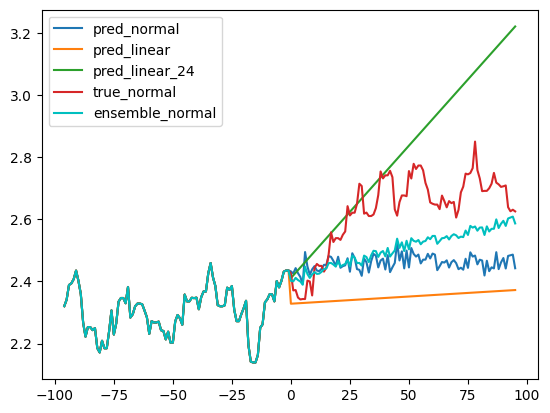

In [41]:
# 그래프 그리기
idx = 474
val = 7
xval = range(args.pred_len)
xval2 = range(-args.seq_len, args.pred_len)
plt.plot(xval2, np.concatenate([np_true[idx-args.pred_len, -args.seq_len:, val], np_pred[idx, :, val]]), label='pred_normal')
plt.plot(xval2, np.concatenate([np_true[idx-args.pred_len, -args.seq_len::, val],np_pred_lin[idx, :, val]]), label='pred_linear')
plt.plot(xval2, np.concatenate([np_true[idx-args.pred_len, -args.seq_len::, val],np_pred_lin_24[idx, :, val]]), label='pred_linear_24')
plt.plot(xval2, np.concatenate([np_true[idx-args.pred_len, -args.seq_len::, val],np_true[idx, :, val]]), label='true_normal')
plt.plot(xval2, np.concatenate([np_true[idx-args.pred_len, -args.seq_len::, val],final_res[idx, :, val]]),'c', label='ensemble_normal')
plt.legend()
plt.show()

In [42]:
# 결과 저장
save_dir = f"./results/{setting_path}/"
np.save(save_dir + 'pred_lin_combi.npy', final_res)
np.save(save_dir + 'pred_lin.npy', np_pred_lin)
np.save(save_dir + 'pred_lin24.npy', np_pred_lin_24)